In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from itertools import product
from typing import Union
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

from chapter7 import ad_fuller_result

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data # 미국 거시경제 데이터 로드
macro_econ_data #11개의 외생변수

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


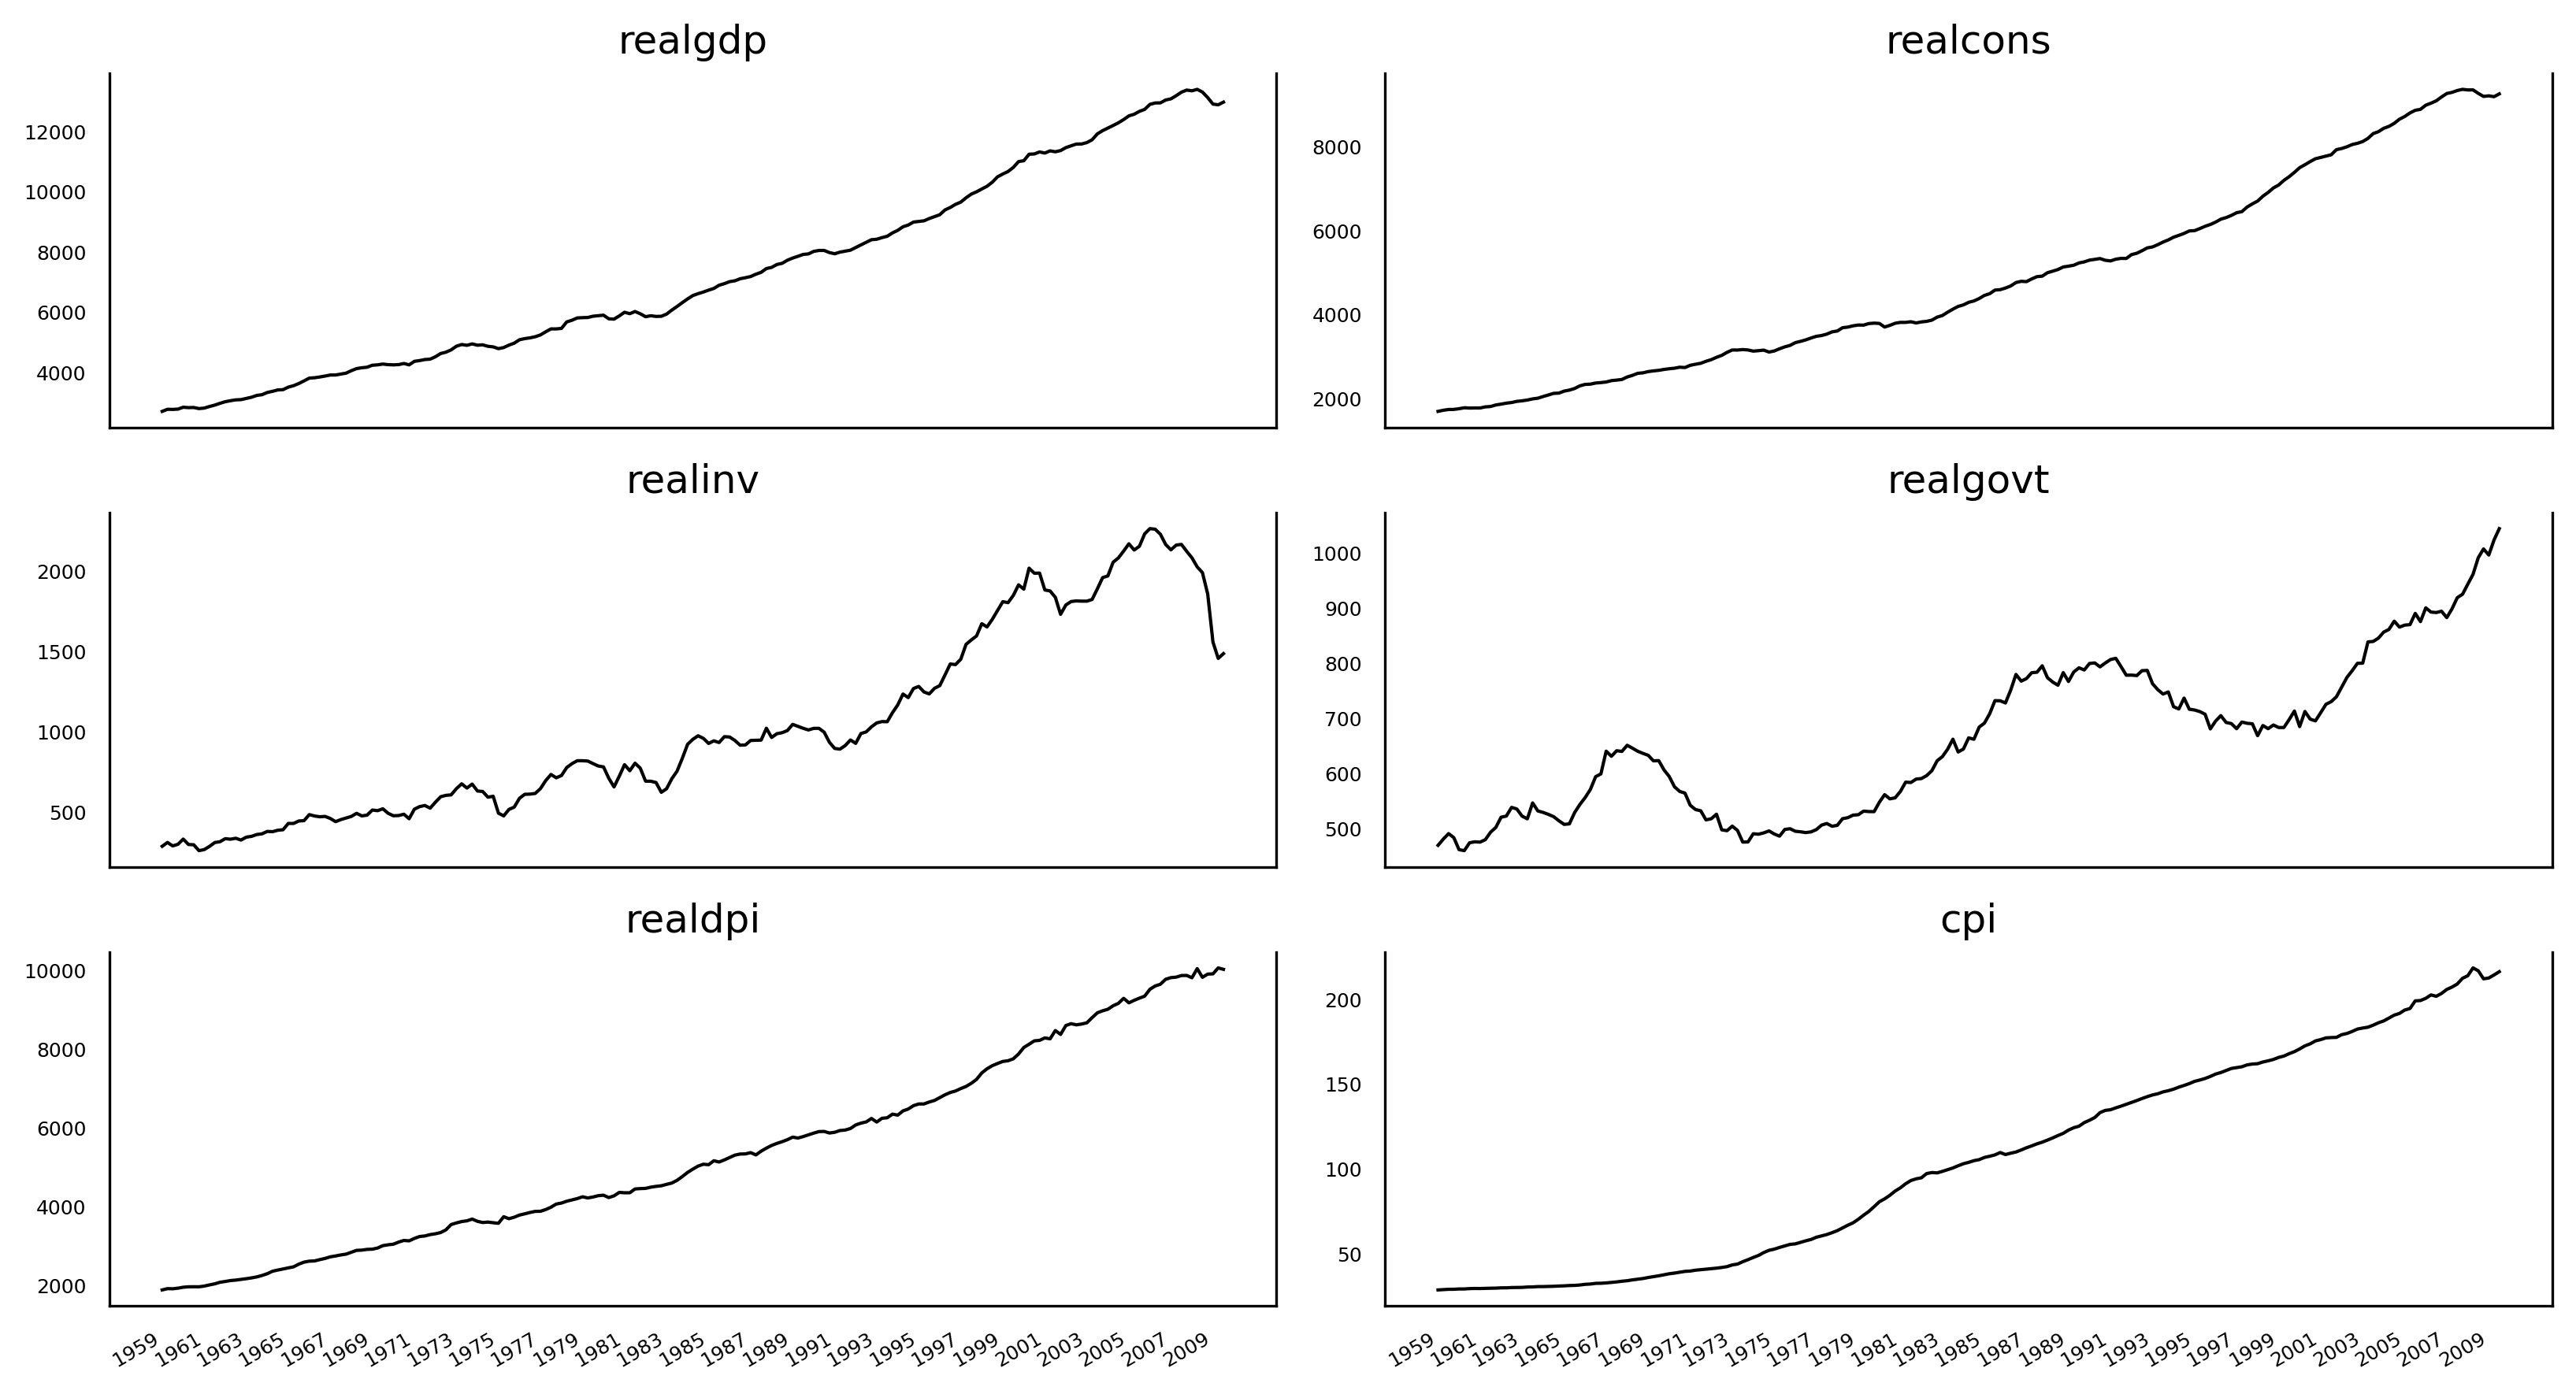

In [3]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]

    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.tight_layout()

In [4]:
target = macro_econ_data['realgdp'] #대상변수
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']] #외생변수

ad_fuller_result = adfuller(target)

print(ad_fuller_result[0])
print(ad_fuller_result[1])

1.7504627967647102
0.9982455372335032


In [5]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(ad_fuller_result[0])
print(ad_fuller_result[1])

-6.305695561658104
3.327882187668259e-08


In [8]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)

        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)','AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [9]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [10]:
target_train = target[:200]
exog_train = exog[:200]

In [11]:
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  4%|▍         | 11/256 [00:01<00:37,  6.47it/s]/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 13/256 [00:01<00:42,  5.65it/s]/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  5%|▌         | 14/256 [00:02<00:47,  5.13it/s]/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  6%|▌         | 15/256 [00:02<00:52,  4.58it/s]/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarn

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.820882
1,"(3, 3, 1, 0)",1744.967503
2,"(3, 3, 0, 1)",1744.998574
3,"(2, 2, 0, 0)",1745.418286
4,"(2, 2, 0, 1)",1746.253253
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


In [12]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.410
Date:                Mon, 10 Mar 2025   AIC                           1742.821
Time:                        20:09:00   BIC                           1782.341
Sample:                             0   HQIC                          1758.816
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9699      0.045     21.578      0.000       0.882       1.058
realinv        1.0136      0.033     30.782      0.000       0.949       1.078
realgovt       0.7283      0.127      5.738      0.0

/home/seongwoo/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


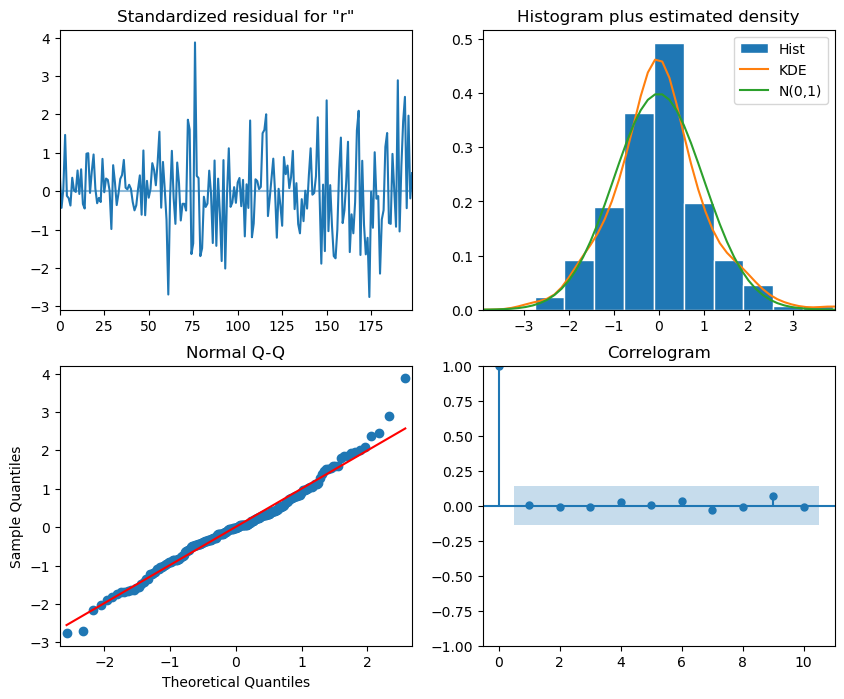

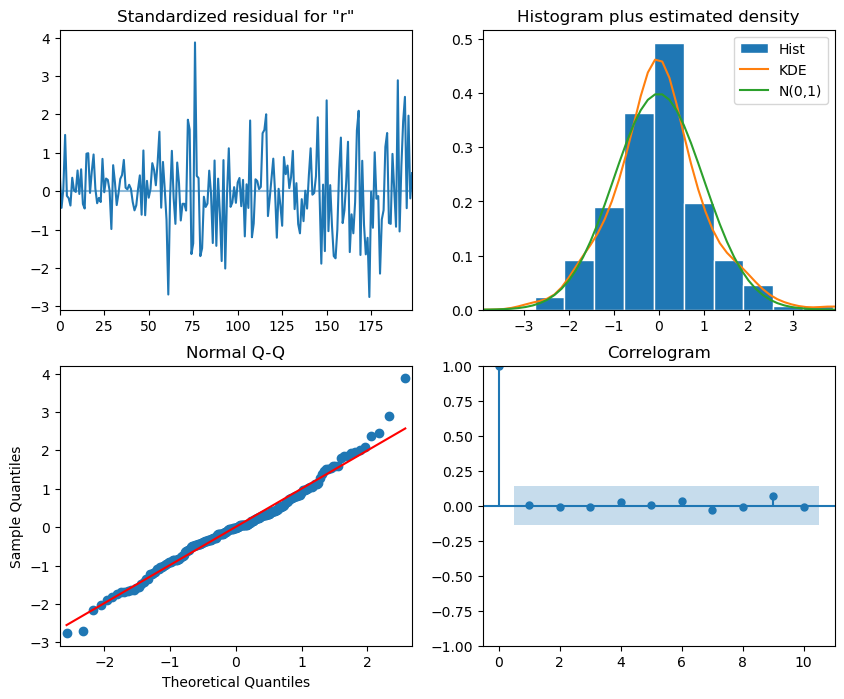

In [13]:
best_model_fit.plot_diagnostics(figsize=(10,8))

In [14]:
residuals = best_model_fit.resid

k = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(k)

     lb_stat  lb_pvalue
1   0.092280   0.761298
2   0.204045   0.903009
3   0.206715   0.976498
4   1.237704   0.871853
5   1.238809   0.941100
6   1.263748   0.973619
7   1.458705   0.983705
8   1.468984   0.993211
9   1.840068   0.993752
10  1.846150   0.997389
